<a href="https://colab.research.google.com/github/andres-tovar-purdue/materials/blob/main/HGP_BO_TPS_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gpflow==2.9.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.6/380.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 5.6 MB/s eta 0:00:00


In [2]:
import tensorflow
import gpflow
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Vanilla GP model
def train_gp_model(X, y, k='m32'):
    if k == 'm32':
      kernel = gpflow.kernels.Matern32()
    elif k == 'm52':
      kernel = gpflow.kernels.Matern52()
    elif k == 'rbf':
      kernel = gpflow.kernels.RBF()
    elif k == 'sqex':
      kernel = gpflow.kernels.SquaredExponential()
    elif k == 'linear':
      kernel = gpflow.kernels.Linear()
    elif k == 'white':
      kernel = gpflow.kernels.White()
    else:
      raise ValueError("Invalid kernel type. Must be 'm32', 'm52', 'rbf', 'sqex', 'linear, or 'white'.")
    model = gpflow.models.GPR(data=(X, y), kernel=kernel, mean_function=None)
    opt = gpflow.optimizers.Scipy()
    opt.minimize(model.training_loss, model.trainable_variables)
    return model

# GP model with prescribed lambda_
def train_gp2_model(X, y, k='m32', lambda_=1e-3):
    if k == 'm32':
      kernel = gpflow.kernels.Matern32()
    elif k == 'm52':
      kernel = gpflow.kernels.Matern52()
    elif k == 'rbf':
      kernel = gpflow.kernels.RBF()
    elif k == 'sqex':
      kernel = gpflow.kernels.SquaredExponential()
    elif k == 'linear':
      kernel = gpflow.kernels.Linear()
    elif k == 'white':
      kernel = gpflow.kernels.White()
    else:
      raise ValueError("Invalid kernel type. Must be 'm32', 'm52', 'rbf', 'sqex', 'linear, or 'white'.")
    model = gpflow.models.GPR(data=(X, y), kernel=kernel, mean_function=None)
    model.likelihood.variance.assign(lambda_)
    gpflow.set_trainable(model.likelihood.variance, False)
    opt = gpflow.optimizers.Scipy()
    opt.minimize(model.training_loss, variables=model.trainable_variables)
    return model

# Periodic GP
def train_pgp_model(X, y, k='m32'):
    if k == 'm32':
      kernel = gpflow.kernels.Matern32()
    elif k == 'm52':
      kernel = gpflow.kernels.Matern52()
    elif k == 'rbf':
      kernel = gpflow.kernels.RBF()
    elif k == 'sqex':
      kernel = gpflow.kernels.SquaredExponential()
    elif k == 'linear':
      kernel = gpflow.kernels.Linear()
    elif k == 'white':
      kernel = gpflow.kernels.White()
    else:
      raise ValueError("Invalid kernel type. Must be 'm32', 'm52', 'rbf', 'sqex', 'linear, or 'white'.")
    # kernel = gpflow.kernels.Periodic(kernel, period=0.3)
    kernel = gpflow.kernels.Periodic(kernel)
    model = gpflow.models.GPR(data=(X, y), kernel=kernel, mean_function=None)
    opt = gpflow.optimizers.Scipy()
    opt.minimize(model.training_loss, model.trainable_variables)
    return model

# Periodic GP with prescribed lambda_
def train_pgp2_model(X, y, k='m32', lambda_=1e-3):
    if k == 'm32':
      kernel = gpflow.kernels.Matern32()
    elif k == 'm52':
      kernel = gpflow.kernels.Matern52()
    elif k == 'rbf':
      kernel = gpflow.kernels.RBF()
    elif k == 'sqex':
      kernel = gpflow.kernels.SquaredExponential()
    elif k == 'linear':
      kernel = gpflow.kernels.Linear()
    elif k == 'white':
      kernel = gpflow.kernels.White()
    else:
      raise ValueError("Invalid kernel type. Must be 'm32', 'm52', 'rbf', 'sqex', 'linear, or 'white'.")
    # kernel = gpflow.kernels.Periodic(kernel, period=0.3)
    kernel = gpflow.kernels.Periodic(kernel)
    model = gpflow.models.GPR(data=(X, y), kernel=kernel, mean_function=None)
    model.likelihood.variance.assign(lambda_)
    gpflow.set_trainable(model.likelihood.variance, False)
    opt = gpflow.optimizers.Scipy()
    opt.minimize(model.training_loss, model.trainable_variables)
    return model

In [4]:
# Expected Improvement function for minimization
from scipy.stats import norm
def expected_improvement(y_best, f_mean, f_std):
    delta = y_best - f_mean
    with np.errstate(divide='ignore'):
        Z = delta / f_std
        ei = delta * norm.cdf(Z) + f_std * norm.pdf(Z)
        ei[f_std == 0.0] = 0.0
    return ei

In [5]:
# Plotting countour.
def plot_contour(X1, X2, Z, title="", color_map='viridis', dpi=300, scale=1/0.67):
  # Scale
  # use scale = 1 if the paper has two figures in a row
  # use scale = 1/0.67 if the paper has three figures in a row
  # use scale = 1/0.5 if the paper has four figures in a row

  # Plotting
  fontsize  = 5*scale
  linewidth = 1*scale
  mark_size = 3*scale

  # Plot preparation
  fig, ax = plt.subplots(1, 1, figsize=(3.25, 2.75), dpi=dpi)
  fig.tight_layout(pad=3.0)

  c1 = ax.contourf(X1, X2, Z, cmap=color_map, levels=15)
  c2 = ax.contour(X1, X2, Z, colors='black', linewidths=linewidth/2, levels=15)

  # ax.set_aspect('equal')
  ax.set_title(title, fontsize=fontsize)
  # ax.clabel(c2, inline=1, fmt='%1.2f', fontsize=fontsize)
  ax.tick_params(axis='both', which='major', labelsize=fontsize)
  ax.set_xlabel('$x_1$', fontsize=fontsize)
  ax.set_ylabel('$x_2$', fontsize=fontsize)
  # plt.show()

  return fig, ax

In [6]:
# Rectangle
import matplotlib.patches as patches
def get_rectangle(x1mean, x2mean, linewidth=1):

  # Identify min and max
  x1min = np.min(x1mean)
  x1max = np.max(x1mean)
  x2min = np.min(x2mean)
  x2max = np.max(x2mean)

  x1_length = x1max - x1min
  x2_length = x2max - x2min
  # print(x1_length, x2_length)

  # Rectangle
  rectangle = patches.Rectangle((x1min, x2min), x1_length, x2_length, linewidth=linewidth, edgecolor='k', facecolor='none')

  return rectangle

In [7]:
def plot_contour2(X1, X2, Z, XX1, XX2, ZZ, title="", color_map='viridis', dpi=300, scale=1/0.67):
  # Plotting
  fontsize  = 5*scale
  linewidth = 1*scale
  mark_size = 3*scale

  # Plot preparation
  fig, ax = plt.subplots(1, 1, figsize=(3.25, 2.75), dpi=dpi)
  fig.tight_layout(pad=2.5)

  c3 = ax.contourf(XX1, XX2, ZZ, cmap='Blues', levels=30)
  c1 = ax.contourf(X1, X2, Z, cmap=color_map, levels=15)
  # c1 = ax.contourf(X1, X2, Z, cmap='Blues', levels=15)
  c2 = ax.contour(X1, X2, Z, colors='black', linewidths=linewidth/2, levels=15)
  # c4 = ax.contour(XX1, XX2, ZZ, colors='black', linewidths=linewidth/2, levels=15)

  # ax.set_aspect('equal')
  ax.set_title(title, fontsize=fontsize)
  # ax.clabel(c2, inline=1, fmt='%1.2f', fontsize=fontsize)
  ax.tick_params(axis='both', which='major', labelsize=fontsize)
  ax.set_xlabel('$x_1$', fontsize=fontsize)
  ax.set_ylabel('$x_2$', fontsize=fontsize)
  # plt.show()

  return fig, ax


In [8]:
def four_plots(x1_grid, x2_grid, y1mean_mean, y1var_mean, y2mean_mean, y2var_mean,
               x1_grid_plt, x2_grid_plt, y1mean_mean_plt, y1var_mean_plt, y2mean_mean_plt, y2var_mean_plt,
               x1_doe, x2_doe, x11_best, x21_best, x12_best, x22_best,
               x11_new_ei, x21_new_ei, x12_new_ei, x22_new_ei,
               x11_new_lcb, x21_new_lcb, x12_new_lcb, x22_new_lcb,
               x11_other, x21_other, x12_other, x22_other):

  # Plot parameters
  resolution = 200
  scale = 2.5
  markersize = 10*scale

  # Plot y1 mean
  _, ax1 = plot_contour2(x1_grid, x2_grid, y1mean_mean.reshape(x1_grid.shape), x1_grid_plt, x2_grid_plt, y1mean_mean_plt.reshape(x1_grid_plt.shape),
                        title="EB mean", color_map='Blues', dpi=resolution, scale=scale)
  _, ax2 = plot_contour2(x1_grid, x2_grid, y1var_mean.reshape(x1_grid.shape), x1_grid_plt, x2_grid_plt, y1var_mean_plt.reshape(x1_grid_plt.shape),
                        title="EB var", color_map='Blues', dpi=resolution, scale=scale)
  _, ax3 = plot_contour2(x1_grid, x2_grid, y2mean_mean.reshape(x1_grid.shape), x1_grid_plt, x2_grid_plt, y2mean_mean_plt.reshape(x1_grid_plt.shape),
                        title="TS mean", color_map='Blues', dpi=resolution, scale=scale)
  _, ax4 = plot_contour2(x1_grid, x2_grid, y2var_mean.reshape(x1_grid.shape), x1_grid_plt, x2_grid_plt, y2var_mean_plt.reshape(x1_grid.shape),
                        title="TS var", color_map='Blues', dpi=resolution, scale=scale)

  # Limits
  x1_plt_min = np.min(x1_grid_plt)
  x1_plt_max = np.max(x1_grid_plt)
  x2_plt_min = np.min(x2_grid_plt)
  x2_plt_max = np.max(x2_grid_plt)
  ax1.set_xlim(x1_plt_min, x1_plt_max)
  ax1.set_ylim(x2_plt_min, x2_plt_max)
  ax2.set_xlim(x1_plt_min, x1_plt_max)
  ax2.set_ylim(x2_plt_min, x2_plt_max)
  ax3.set_xlim(x1_plt_min, x1_plt_max)
  ax3.set_ylim(x2_plt_min, x2_plt_max)
  ax4.set_xlim(x1_plt_min, x1_plt_max)
  ax4.set_ylim(x2_plt_min, x2_plt_max)

  # Rectangles of exploration regions
  ax1.add_patch(get_rectangle(x1_grid, x2_grid, linewidth=0.67))
  ax2.add_patch(get_rectangle(x1_grid, x2_grid, linewidth=0.67))
  ax3.add_patch(get_rectangle(x1_grid, x2_grid, linewidth=0.67))
  ax4.add_patch(get_rectangle(x1_grid, x2_grid, linewidth=0.67))

  # Scatter plot of DOE
  ax1.scatter(x1_doe, x2_doe, color='r', s=markersize, alpha=0.8)
  ax2.scatter(x1_doe, x2_doe, color='r', s=markersize, alpha=0.8)
  ax3.scatter(x1_doe, x2_doe, color='r', s=markersize, alpha=0.8)
  ax4.scatter(x1_doe, x2_doe, color='r', s=markersize, alpha=0.8)

  # Scatter plot of DOE best
  ax1.scatter(x11_best, x21_best, color='k', s=markersize, alpha=1)
  ax2.scatter(x11_best, x21_best, color='k', s=markersize, alpha=1)
  ax3.scatter(x12_best, x22_best, color='k', s=markersize, alpha=1)
  ax4.scatter(x12_best, x22_best, color='k', s=markersize, alpha=1)

  # Scatter plot of max EI
  ax1.scatter(x11_new_ei, x21_new_ei, marker='D', edgecolors='black', facecolors='white', s=markersize, alpha=0.8)
  ax2.scatter(x11_new_ei, x21_new_ei, marker='D', edgecolors='black', facecolors='white', s=markersize, alpha=0.8)
  ax3.scatter(x12_new_ei, x22_new_ei, marker='D', edgecolors='black', facecolors='white', s=markersize, alpha=0.8)
  ax4.scatter(x12_new_ei, x22_new_ei, marker='D', edgecolors='black', facecolors='white', s=markersize, alpha=0.8)

  # Scatter plot of min LCB
  ax1.scatter(x11_new_lcb, x21_new_lcb, marker='s', edgecolors='black', facecolors='white', s=markersize, alpha=0.8)
  ax2.scatter(x11_new_lcb, x21_new_lcb, marker='s', edgecolors='black', facecolors='white', s=markersize, alpha=0.8)
  ax3.scatter(x12_new_lcb, x22_new_lcb, marker='s', edgecolors='black', facecolors='white', s=markersize, alpha=0.8)
  ax4.scatter(x12_new_lcb, x22_new_lcb, marker='s', edgecolors='black', facecolors='white', s=markersize, alpha=0.8)

  # Scatter plot of other
  ax1.scatter(x11_other, x21_other, marker='x', color='k', s=markersize, alpha=1)
  ax2.scatter(x11_other, x21_other, marker='x', color='k', s=markersize, alpha=1)
  ax3.scatter(x12_other, x22_other, marker='x', color='k', s=markersize, alpha=1)
  ax4.scatter(x12_other, x22_other, marker='x', color='k', s=markersize, alpha=1)


In [9]:
# Exploration region - rounded
def x_grid_fun(x1vec, x2vec, scale=1):

  # Identify min and max
  x1min = np.min(x1vec)
  x1max = np.max(x1vec)
  x2min = np.min(x2vec)
  x2max = np.max(x2vec)

  x1_length = x1max - x1min
  x2_length = x2max - x2min
  # print(x1_length, x2_length)

  # Limits
  x1_LB = x1min - 0.5*x1_length*scale
  x1_UB = x1max + 0.5*x1_length*scale
  x2_LB = x2min - 0.5*x2_length*scale
  x2_UB = x2max + 0.5*x2_length*scale

  # Correction of limits
  x1_LB = max(x1_abs_min, x1_LB)
  x1_UB = min(x1_abs_max, x1_UB)
  x2_LB = max(x2_abs_min, x2_LB)
  x2_UB = min(x2_abs_max, x2_UB)

  # Round
  x1_LB = np.round(2*x1_LB)/2
  x1_UB = np.round(2*x1_UB)/2
  x2_LB = np.round(2*x2_LB)/2
  x2_UB = np.round(2*x2_UB)/2

  print(x1_LB, x1_UB, x2_LB, x2_UB)

  # Grid
  x1_lin = np.linspace(x1_LB, x1_UB, 100)
  x2_lin = np.linspace(x2_LB, x2_UB, 100)
  x1_grid, x2_grid = np.meshgrid(x1_lin, x2_lin)
  X_grid = np.vstack((x1_grid.flatten(), x2_grid.flatten())).T

  return X_grid, x1_grid, x2_grid

In [10]:
# Add corner points
def get_four_cornes(X):
  x1_min = np.min(X[:, 0])
  x2_min = np.min(X[:, 1])
  x1_max = np.max(X[:, 0])
  x2_max = np.max(X[:, 1])
  X_new = np.array([[x1_min, x2_min], [x1_min, x2_max], [x1_max, x2_min], [x1_max, x2_max]])
  return X_new

# Remove duplicates
def remove_duplicates(X_doe, X_new_doe):
  # If the row of X_new_doe is in X_doe, then remove that row from X_new_doe
  rows_to_remove = []
  for i in range(X_new_doe.shape[0]):
    if any(np.allclose(X_new_doe[i], row) for row in X_doe):
      rows_to_remove.append(i)
  X_new_doe = np.delete(X_new_doe, rows_to_remove, axis=0)
  x1_new = X_new_doe[:, 0]
  x2_new = X_new_doe[:, 1]
  return X_new_doe, x1_new, x2_new


In [11]:
# Predictions function
def prediction_fun(X_grid, y1mean_model, y1var_model, y2mean_model, y2var_model):

  # Predictions of log values
  y1mean_mean, y1mean_var = y1mean_model.predict_f(X_grid)
  y1var_mean, y1var_var = y1var_model.predict_f(X_grid)
  y2mean_mean, y2mean_var = y2mean_model.predict_f(X_grid)
  y2var_mean, y2var_var = y2var_model.predict_f(X_grid)

  # Correction
  y1mean_mean = np.exp(np.array(y1mean_mean).flatten())
  y1mean_var = np.exp(np.array(y1mean_var).flatten())
  y2mean_mean = np.exp(np.array(y2mean_mean).flatten())
  y2mean_var = np.exp(np.array(y2mean_var).flatten())

  y1var_mean = np.exp(np.array(y1var_mean).flatten())
  y1var_var = np.exp(np.array(y1var_var).flatten())
  y2var_mean = np.exp(np.array(y2var_mean).flatten())
  y2var_var = np.exp(np.array(y2var_var).flatten())

  return y1mean_mean, y1mean_var, y2mean_mean, y2mean_var, y1var_mean, y1var_var, y2var_mean, y2var_var

In [12]:
# Train GP models
def train_model(x1mean, x2mean, y1mean, y1var, y2mean, y2var):
  X = np.vstack((x1mean, x2mean)).T

  # Reshape
  y1mean = y1mean.reshape(-1, 1)
  y2mean = y2mean.reshape(-1, 1)
  y1var = y1var.reshape(-1, 1)
  y2var = y2var.reshape(-1, 1)

  # Logs
  y1mean_data = np.log(y1mean)
  y2mean_data = np.log(y2mean)
  y1var_data = np.log(y1var)
  y2var_data = np.log(y2var)

  # Models
  y1mean_model = train_gp2_model(X, y1mean_data, k='m32', lambda_=1e-3)
  y1var_model = train_gp_model(X, y1var_data, k='m32')
  y2mean_model = train_gp2_model(X, y2mean_data, k='m32', lambda_=1e-3)
  y2var_model = train_gp_model(X, y2var_data, k='m32')

  return y1mean_model, y1var_model, y2mean_model, y2var_model

# Adaptive experimental design

## Variables

In [13]:
# References
# x1: plasticizer
# x2: starch
# y1: elo
# y2: sut

## Predictions and plots

In [14]:
# For the exploration regions
x1_abs_min = 0.5
x1_abs_max = 7
x2_abs_min = 0.5
x2_abs_max = 15
x1_abs_max = np.round(2*x1_abs_max)/2
x2_abs_max = np.round(2*x2_abs_max)/2

print(x1_abs_min, x1_abs_max)
print(x2_abs_min, x2_abs_max)

0.5 7.0
0.5 15.0


In [15]:
# Additional grid for plotting
x1_plt_min = 0
x1_plt_max = x1_abs_max + 1
x2_plt_min = 0
x2_plt_max = x2_abs_max + 1

x1_lin = np.linspace(x1_plt_min, x1_plt_max, 100)
x2_lin = np.linspace(x2_plt_min, x2_plt_max, 100)
x1_grid_plt, x2_grid_plt = np.meshgrid(x1_lin, x2_lin)
Xplt_grid = np.vstack((x1_grid_plt.flatten(), x2_grid_plt.flatten())).T


# DOE 1

In [16]:
# Step 1: Load data from CSV file
data = pd.read_csv('tps_doe_1.csv')
x1mean1 = data['x1'].values.flatten() # plasticizer
x2mean1 = data['x2'].values.flatten() # starch
y1mean1 = data['y1mean'].values.flatten() # elo
y1var1 = data['y1var'].values.flatten() # elo
y2mean1 = data['y2mean'].values.flatten() # sut
y2var1 = data['y2var'].values.flatten() # sut

# Concatenate
X_doe1 = np.vstack((x1mean1, x2mean1)).T

# Exploration region
X_grid1, x1_grid1, x2_grid1 = x_grid_fun(x1mean1, x2mean1, scale=1.5)


0.5 2.0 2.0 12.0


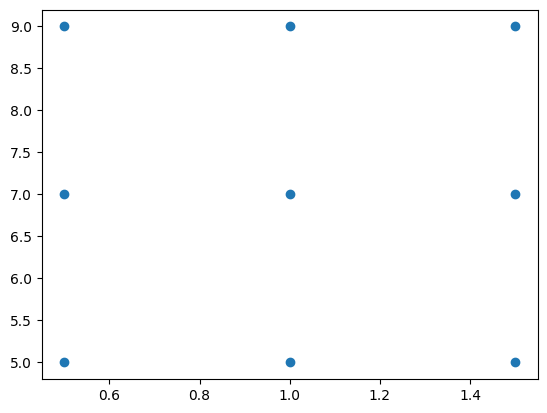

In [17]:
# Plot
plt.scatter(x1mean1, x2mean1)
plt.show()


In [18]:
# Step 2: Obtain the f(x_best)
min1_index = np.argmin(-y1mean1)
min2_index = np.argmin(-y2mean1)
x11_best = x1mean1[min1_index]
x21_best = x2mean1[min1_index]
x12_best = x1mean1[min2_index]
x22_best = x2mean1[min2_index]
y1_best = y1mean1[min1_index]
y2_best = y2mean1[min2_index]

print(x11_best, x21_best, y1_best)
print(x12_best, x22_best, y2_best)

1.5 7.0 23.89621900363716
0.5 7.0 2.7670553804916524


In [19]:
# Step 3: Get models and grid predictions

# Train
y1mean_doe_model1, y1var_doe_model1, y2mean_doe_model1, y2var_doe_model1 = train_model(
    x1mean1, x2mean1, y1mean1, y1var1, y2mean1, y2var1)

# Predictions
y1mean_mean_grid1, y1mean_var_grid1, y2mean_mean_grid1, y2mean_var_grid1, y1var_mean_grid1, y1var_var_grid1, y2var_mean_grid1, y2var_var_grid1 = prediction_fun(
    X_grid1, y1mean_doe_model1, y1var_doe_model1, y2mean_doe_model1, y2var_doe_model1)

# Additional predictions
y1mean_mean_plt, y1mean_var_plt, y2mean_mean_plt, y2mean_var_plt, y1var_mean_plt, y1var_var_plt, y2var_mean_plt, y2var_var_plt = prediction_fun(
    Xplt_grid, y1mean_doe_model1, y1var_doe_model1, y2mean_doe_model1, y2var_doe_model1)


In [20]:
# Step 4: Expected improvement

# Standard deviations (grid)
y1std_grid1 = np.sqrt(y1mean_var_grid1 + y1var_mean_grid1 + y1var_var_grid1)
y2std_grid1 = np.sqrt(y2mean_var_grid1 + y2var_mean_grid1 + y2var_var_grid1)

# Expected improvment of y1
ei1_grid = expected_improvement(-y1_best, -y1mean_mean_grid1, y1std_grid1)
max_ei_index = np.argmax(ei1_grid)
x11_new_ei = x1_grid1.flatten()[max_ei_index]
x21_new_ei = x2_grid1.flatten()[max_ei_index]
x11_new_ei = np.round(x11_new_ei * 2)/2 # Rounded
x21_new_ei = np.round(x21_new_ei * 2)/2 # Rounded
y1_var = y1var_mean_grid1[max_ei_index] + y1var_var_grid1[max_ei_index] + y1mean_var_grid1[max_ei_index]

# Expected improvment of y2
ei2_grid = expected_improvement(-y2_best, -y2mean_mean_grid1, y2std_grid1)
max_ei_index = np.argmax(ei2_grid)
x12_new_ei = x1_grid1.flatten()[max_ei_index]
x22_new_ei = x2_grid1.flatten()[max_ei_index]
x12_new_ei = np.round(x12_new_ei * 2)/2 # Rounded
x22_new_ei = np.round(x22_new_ei * 2)/2 # Rounded
y2_var = y2var_mean_grid1[max_ei_index] + y2var_var_grid1[max_ei_index] + y2mean_var_grid1[max_ei_index]

# Print
iter = 0
print('iter=', iter)
print(x11_new_ei, x21_new_ei)
print(x12_new_ei, x22_new_ei)

# Max EI values
max_ei1= np.max(ei1_grid)
max_ei2= np.max(ei2_grid)

# max ei point var

# Save results in a CSV file
df_res = pd.DataFrame({'iter': [iter],
                       'x11_best': [x11_best], 'x21_best': [x21_best], 'y1_best': [y1_best], 'y1_var': [y1_var], 'max_ei1': [max_ei1],
                       'x12_best': [x12_best], 'x22_best': [x22_best], 'y2_best': [y2_best], 'y2_var': [y2_var], 'max_ei2': [max_ei2]})
# Save results
df_res.to_csv('results1.csv', index=False)


iter= 0
2.0 6.5
0.5 7.5


In [21]:
# Step 5: Lower confidence bound (LCB)

# Initialization
kappa1 = 0.0
kappa2 = 0.0
x11_new_lcb = x11_new_ei
x21_new_lcb = x21_new_ei
x12_new_lcb = x12_new_ei
x22_new_lcb = x22_new_ei

# Lower confidence bound of y1
while (x11_new_lcb == x11_new_ei and x21_new_lcb == x21_new_ei) and kappa1 < 2**12:
  lcb1_grid = -y1mean_mean_grid1 - kappa1*y1std_grid1
  min_lcb_index = np.argmin(lcb1_grid)
  x11_new_lcb = x1_grid1.flatten()[min_lcb_index]
  x21_new_lcb = x2_grid1.flatten()[min_lcb_index]
  x11_new_lcb = np.round(x11_new_lcb * 2)/2 # Rounded
  x21_new_lcb = np.round(x21_new_lcb * 2)/2 # Rounded
  # kappa1 = max(2*kappa1, 1)
  kappa1 = 2**kappa1
  kappa1 += 1

# Lower confidence bound of y2
while (x12_new_lcb == x12_new_ei and x22_new_lcb == x22_new_ei) and kappa2 < 2**12:
  lcb2_grid = -y2mean_mean_grid1 - kappa2*y2std_grid1
  min_lcb_index = np.argmin(lcb2_grid)
  x12_new_lcb = x1_grid1.flatten()[min_lcb_index]
  x22_new_lcb = x2_grid1.flatten()[min_lcb_index]
  x12_new_lcb = np.round(x12_new_lcb * 2)/2 # Rounded
  x22_new_lcb = np.round(x22_new_lcb * 2)/2 # Rounded
  kappa2 = 2**kappa2

# Print
print(x11_new_ei, x21_new_ei)
print(x12_new_ei, x22_new_ei)
print(x11_new_lcb, x21_new_lcb)
print(x12_new_lcb, x22_new_lcb)

2.0 6.5
0.5 7.5
2.0 6.5
0.5 12.0


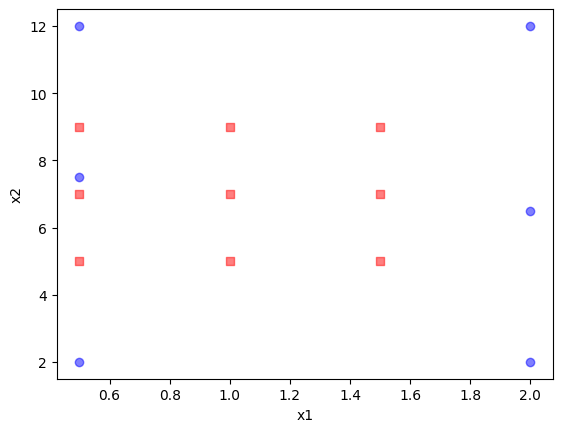

In [22]:
# Step 6: Add corners

# Concatenate EI and LCB points
x1_new = np.concatenate((np.array([x11_new_lcb]), np.array([x11_new_ei]), np.array([x12_new_lcb]), np.array([x12_new_ei])))
x2_new = np.concatenate((np.array([x21_new_lcb]), np.array([x21_new_ei]), np.array([x22_new_lcb]), np.array([x22_new_ei])))

# Add corner points and clean
X_new = np.vstack((x1_new, x2_new)).T
X_four_corners = get_four_cornes(X_grid1)
X_new_plus = np.vstack([X_new, X_four_corners])
X_new_doe1 = np.unique(X_new_plus, axis=0)
X_new_doe1, x1_new_doe1, x2_new_doe1 = remove_duplicates(X_doe1, X_new_doe1)

# Plot check
plt.scatter(x1_new_doe1, x2_new_doe1, color='b', alpha=0.5)
plt.scatter(x1mean1, x2mean1, marker='s', color='r', alpha=0.5)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

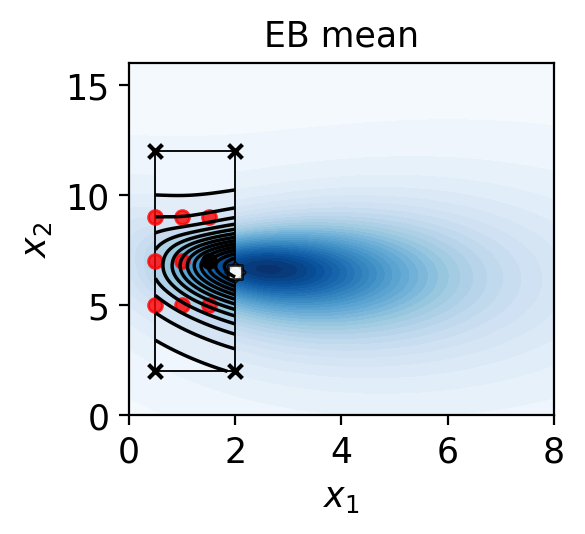

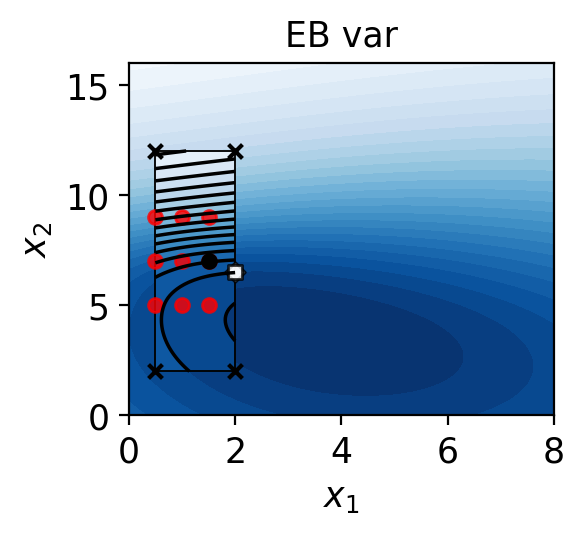

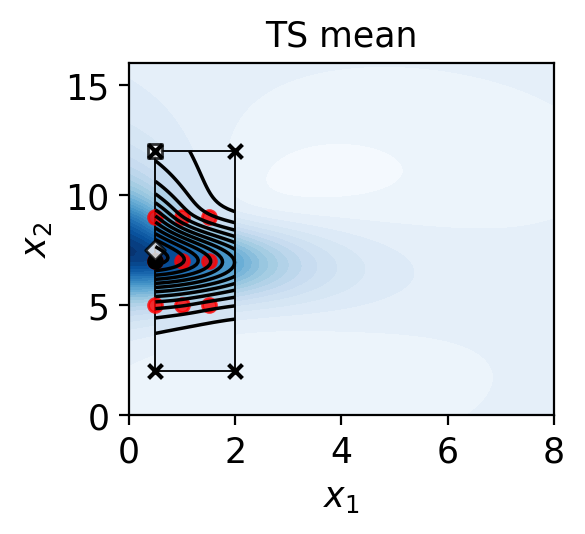

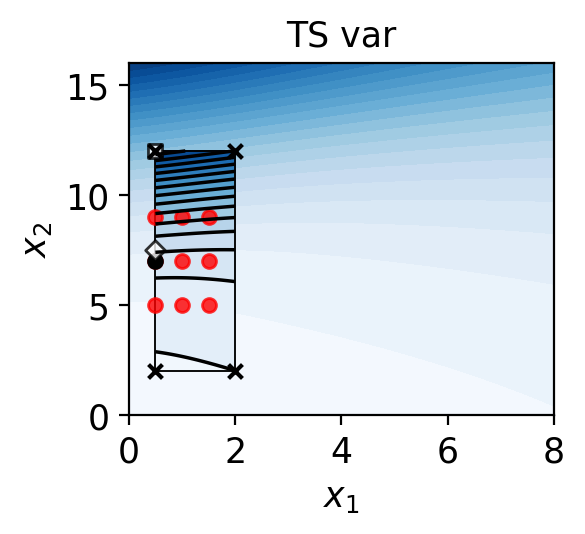

In [23]:
# Step 7: Final plots

# Four plots
four_plots(x1_grid1, x2_grid1, y1mean_mean_grid1, y1var_mean_grid1, y2mean_mean_grid1, y2var_mean_grid1,
               x1_grid_plt, x2_grid_plt, y1mean_mean_plt, y1var_mean_plt, y2mean_mean_plt, y2var_mean_plt,
               x1mean1, x2mean1, x11_best, x21_best, x12_best, x22_best,
               x11_new_ei, x21_new_ei, x12_new_ei, x22_new_ei,
               x11_new_lcb, x21_new_lcb, x12_new_lcb, x22_new_lcb,
               X_four_corners[:,0], X_four_corners[:,1], X_four_corners[:,0], X_four_corners[:,1])

# DOE 2

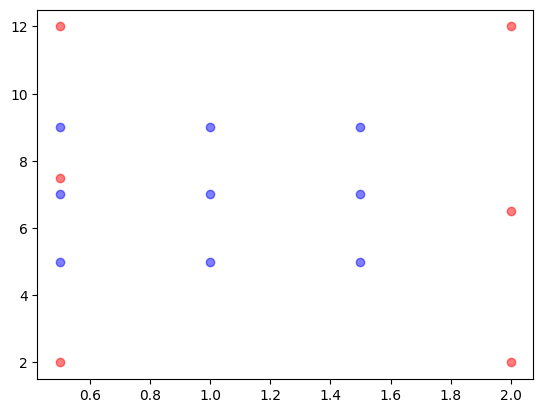

In [24]:
# Check plot
plt.scatter(x1mean1, x2mean1, color='b', alpha=0.5)
plt.scatter(X_new_doe1[:,0], X_new_doe1[:,1], color='r', alpha=0.5)
plt.show()

In [25]:
# Step 1: Load data from CSV file
data = pd.read_csv('tps_doe_2.csv')
x1mean2 = data['x1'].values.flatten() # plasticizer
x2mean2 = data['x2'].values.flatten() # starch
y1mean2 = data['y1mean'].values.flatten() # elo
y1var2 = data['y1var'].values.flatten() # elo
y2mean2 = data['y2mean'].values.flatten() # sut
y2var2 = data['y2var'].values.flatten() # sut

# Collect data
X_doe2 = np.vstack((x1mean2, x2mean2)).T

# Exploration region
X_grid2, x1_grid2, x2_grid2 = x_grid_fun(x1mean2, x2mean2, scale=1.5)

0.5 3.0 0.5 15.0


In [26]:
# Step 2: Train GP models



In [27]:
# Step 3: Obtain the f(x_best)
min1_index = np.argmin(-y1mean2)
min2_index = np.argmin(-y2mean2)
x11_best = x1mean2[min1_index]
x21_best = x2mean2[min1_index]
x12_best = x1mean2[min2_index]
x22_best = x2mean2[min2_index]
y1_best = y1mean2[min1_index]
y2_best = y2mean2[min2_index]

print(x11_best, x21_best, y1_best)
print(x12_best, x22_best, y2_best)

2.0 2.0 69.76118695712272
0.5 7.0 2.7670553804916524


In [28]:
# Step 3: Get models and grid predictions

# Train
y1mean_doe_model2, y1var_doe_model2, y2mean_doe_model2, y2var_doe_model2 = train_model(
    x1mean2, x2mean2, y1mean2, y1var2, y2mean2, y2var2)

# Predictions
y1mean_mean_grid2, y1mean_var_grid2, y2mean_mean_grid2, y2mean_var_grid2, y1var_mean_grid2, y1var_var_grid2, y2var_mean_grid2, y2var_var_grid2 = prediction_fun(
    X_grid2, y1mean_doe_model2, y1var_doe_model2, y2mean_doe_model2, y2var_doe_model2)

# Additional predictions
y1mean_mean_plt, y1mean_var_plt, y2mean_mean_plt, y2mean_var_plt, y1var_mean_plt, y1var_var_plt, y2var_mean_plt, y2var_var_plt = prediction_fun(
    Xplt_grid, y1mean_doe_model2, y1var_doe_model2, y2mean_doe_model2, y2var_doe_model2)


In [29]:
# Step 4: Expected improvement
y1std_grid2 = np.sqrt(y1mean_var_grid2 + y1var_mean_grid2 + y1var_var_grid2)
y2std_grid2 = np.sqrt(y2mean_var_grid2 + y2var_mean_grid2 + y2var_var_grid2)

# Expected improvment of y1
ei1_grid = expected_improvement(-y1_best, -y1mean_mean_grid2, y1std_grid2)
max_ei_index = np.argmax(ei1_grid)
x11_new_ei = x1_grid2.flatten()[max_ei_index]
x21_new_ei = x2_grid2.flatten()[max_ei_index]
x11_new_ei = np.round(x11_new_ei * 2)/2 # Rounded
x21_new_ei = np.round(x21_new_ei * 2)/2 # Rounded
y1_var = y1var_mean_grid2[max_ei_index] + y1var_var_grid2[max_ei_index] + y1mean_var_grid2[max_ei_index]

# Expected improvment of y2
ei2_grid = expected_improvement(-y2_best, -y2mean_mean_grid2, y2std_grid2)
max_ei_index = np.argmax(ei2_grid)
x12_new_ei = x1_grid2.flatten()[max_ei_index]
x22_new_ei = x2_grid2.flatten()[max_ei_index]
x12_new_ei = np.round(x12_new_ei * 2)/2 # Rounded
x22_new_ei = np.round(x22_new_ei * 2)/2 # Rounded
y2_var = y2var_mean_grid2[max_ei_index] + y2var_var_grid2[max_ei_index] + y2mean_var_grid2[max_ei_index]

# Print
iter = 1
print('iter=', iter)
print(x11_new_ei, x21_new_ei)
print(x12_new_ei, x22_new_ei)

# Max EI values
max_ei1= np.max(ei1_grid)
max_ei2= np.max(ei2_grid)

# Save results in a CSV file
df_res = pd.DataFrame({'iter': [iter],
                       'x11_best': [x11_best], 'x21_best': [x21_best], 'y1_best': [y1_best], 'y1_var': [y1_var], 'max_ei1': [max_ei1],
                       'x12_best': [x12_best], 'x22_best': [x22_best], 'y2_best': [y2_best], 'y2_var': [y2_var], 'max_ei2': [max_ei2]})

# Save results
df_res1 = pd.read_csv('results1.csv')
df_res2 = pd.concat([df_res1, df_res], ignore_index=True)
df_res2.to_csv('results2.csv', index=False)

iter= 1
3.0 1.0
0.5 7.0


In [30]:
# Step 5: Lower confidence bound (LCB)

# Initialization
kappa1 = 0.0
kappa2 = 0.0
x11_new_lcb = x11_new_ei
x21_new_lcb = x21_new_ei
x12_new_lcb = x12_new_ei
x22_new_lcb = x22_new_ei

# Lower confidence bound of y1
while (x11_new_lcb == x11_new_ei and x21_new_lcb == x21_new_ei) and kappa1 < 2**12:
  lcb1_grid = -y1mean_mean_grid2 - kappa1*y1std_grid2
  min_lcb_index = np.argmin(lcb1_grid)
  x11_new_lcb = x1_grid2.flatten()[min_lcb_index]
  x21_new_lcb = x2_grid2.flatten()[min_lcb_index]
  x11_new_lcb = np.round(x11_new_lcb * 2)/2 # Rounded
  x21_new_lcb = np.round(x21_new_lcb * 2)/2 # Rounded
  # kappa1 = max(2*kappa1, 1)
  kappa1 = 2**kappa1
  kappa1 += 1

# Lower confidence bound of y2
while (x12_new_lcb == x12_new_ei and x22_new_lcb == x22_new_ei) and kappa2 < 2**12:
  lcb2_grid = -y2mean_mean_grid2 - kappa2*y2std_grid2
  min_lcb_index = np.argmin(lcb2_grid)
  x12_new_lcb = x1_grid2.flatten()[min_lcb_index]
  x22_new_lcb = x2_grid2.flatten()[min_lcb_index]
  x12_new_lcb = np.round(x12_new_lcb * 2)/2 # Rounded
  x22_new_lcb = np.round(x22_new_lcb * 2)/2 # Rounded
  kappa2 = 2**kappa2

# Print
print(x11_new_ei, x21_new_ei)
print(x12_new_ei, x22_new_ei)
print(x11_new_lcb, x21_new_lcb)
print(x12_new_lcb, x22_new_lcb)

3.0 1.0
0.5 7.0
3.0 0.5
3.0 15.0


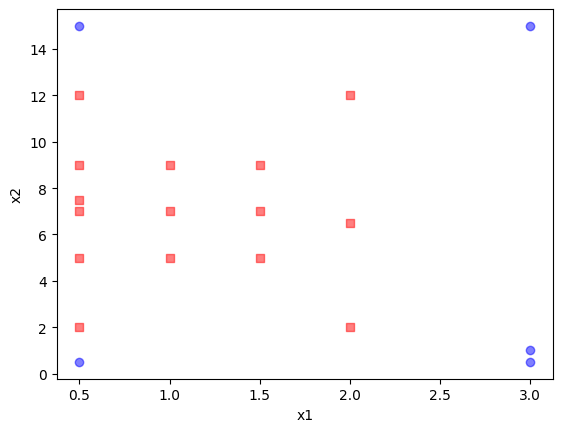

In [31]:
# Step 6: Add corners

# Concatenate EI and LCB points
x1_new = np.concatenate((np.array([x11_new_lcb]), np.array([x11_new_ei]), np.array([x12_new_lcb]), np.array([x12_new_ei])))
x2_new = np.concatenate((np.array([x21_new_lcb]), np.array([x21_new_ei]), np.array([x22_new_lcb]), np.array([x22_new_ei])))

# Add corner points and clean
X_new = np.vstack((x1_new, x2_new)).T
X_four_corners = get_four_cornes(X_grid2)
X_new_plus = np.vstack([X_new, X_four_corners])
X_new_doe2 = np.unique(X_new_plus, axis=0)
X_new_doe2, x1_new_doe2, x2_new_doe2 = remove_duplicates(X_doe2, X_new_doe2)

# Plot check
plt.scatter(x1_new_doe2, x2_new_doe2, color='b', alpha=0.5)
plt.scatter(x1mean2, x2mean2, marker='s', color='r', alpha=0.5)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

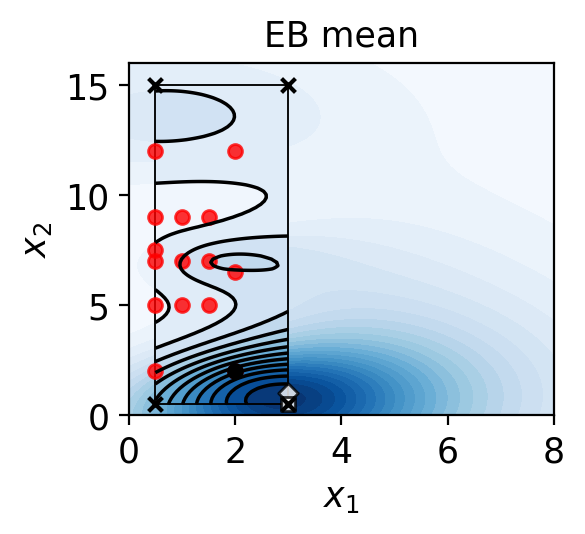

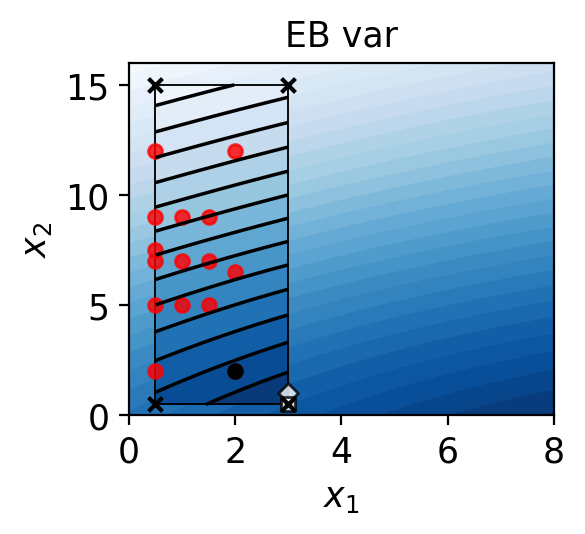

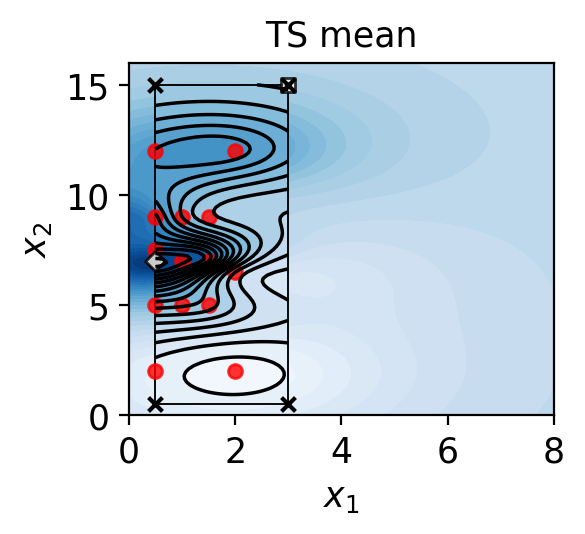

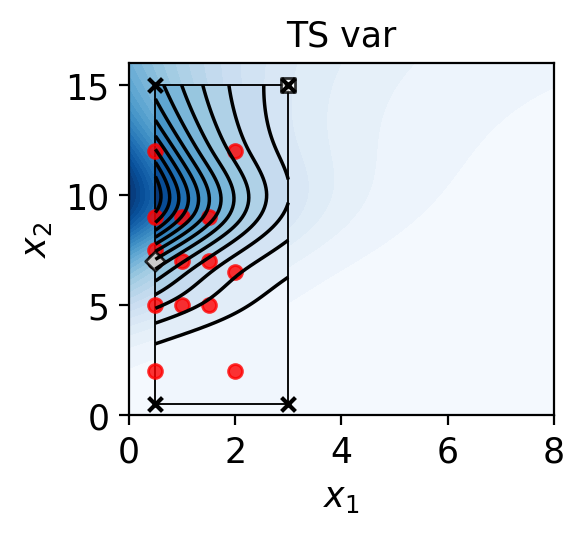

In [32]:
# Step 7: Final plots

# Four plots
four_plots(x1_grid2, x2_grid2, y1mean_mean_grid2, y1var_mean_grid2, y2mean_mean_grid2, y2var_mean_grid2,
               x1_grid_plt, x2_grid_plt, y1mean_mean_plt, y1var_mean_plt, y2mean_mean_plt, y2var_mean_plt,
               x1mean2, x2mean2, x11_best, x21_best, x12_best, x22_best,
               x11_new_ei, x21_new_ei, x12_new_ei, x22_new_ei,
               x11_new_lcb, x21_new_lcb, x12_new_lcb, x22_new_lcb,
               X_four_corners[:,0], X_four_corners[:,1], X_four_corners[:,0], X_four_corners[:,1])

## DOE 3

In [33]:
# Step 1: Load data from CSV file
data = pd.read_csv('tps_doe_3.csv')
x1mean3 = data['x1'].values.flatten() # plasticizer
x2mean3 = data['x2'].values.flatten() # starch
y1mean3 = data['y1mean'].values.flatten() # elo
y1var3 = data['y1var'].values.flatten() # elo
y2mean3 = data['y2mean'].values.flatten() # sut
y2var3 = data['y2var'].values.flatten() # sut

# Collect data
X_doe3 = np.vstack((x1mean3, x2mean3)).T

# Exploration region
X_grid3, x1_grid3, x2_grid3 = x_grid_fun(x1mean3, x2mean3, scale=1.5)


0.5 5.0 0.5 15.0


In [34]:
# Step 2: Obtain the f(x_best)
min1_index = np.argmin(-y1mean3)
min2_index = np.argmin(-y2mean3)
x11_best = x1mean3[min1_index]
x21_best = x2mean3[min1_index]
x12_best = x1mean3[min2_index]
x22_best = x2mean3[min2_index]
y1_best = y1mean3[min1_index]
y2_best = y2mean3[min2_index]

print(x11_best, x21_best, y1_best)
print(x12_best, x22_best, y2_best)

2.0 2.0 69.76118695712272
0.5 7.0 2.7670553804916524


In [35]:
# Step 3: Get models and grid predictions

# Train
y1mean_doe_model3, y1var_doe_model3, y2mean_doe_model3, y2var_doe_model3 = train_model(
    x1mean3, x2mean3, y1mean3, y1var3, y2mean3, y2var3)

# Predictions
y1mean_mean_grid3, y1mean_var_grid3, y2mean_mean_grid3, y2mean_var_grid3, y1var_mean_grid3, y1var_var_grid3, y2var_mean_grid3, y2var_var_grid3 = prediction_fun(
    X_grid3, y1mean_doe_model3, y1var_doe_model3, y2mean_doe_model3, y2var_doe_model3)

# Additional predictions
y1mean_mean_plt, y1mean_var_plt, y2mean_mean_plt, y2mean_var_plt, y1var_mean_plt, y1var_var_plt, y2var_mean_plt, y2var_var_plt = prediction_fun(
    Xplt_grid, y1mean_doe_model3, y1var_doe_model3, y2mean_doe_model3, y2var_doe_model3)

In [36]:
# Step 4: Expected improvement
y1std_grid3 = np.sqrt(y1mean_var_grid3 + y1var_mean_grid3 + y1var_var_grid3)
y2std_grid3 = np.sqrt(y2mean_var_grid3 + y2var_mean_grid3 + y2var_var_grid3)

# Expected improvment of y1
ei1_grid = expected_improvement(-y1_best, -y1mean_mean_grid3, y1std_grid3)
max_ei_index = np.argmax(ei1_grid)
x11_new_ei = x1_grid3.flatten()[max_ei_index]
x21_new_ei = x2_grid3.flatten()[max_ei_index]
x11_new_ei = np.round(x11_new_ei * 2)/2 # Rounded
x21_new_ei = np.round(x21_new_ei * 2)/2 # Rounded
y1_var = y1var_mean_grid3[max_ei_index] + y1var_var_grid3[max_ei_index] + y1mean_var_grid3[max_ei_index]

# Expected improvment of y2
ei2_grid = expected_improvement(-y2_best, -y2mean_mean_grid3, y2std_grid3)
max_ei_index = np.argmax(ei2_grid)
x12_new_ei = x1_grid3.flatten()[max_ei_index]
x22_new_ei = x2_grid3.flatten()[max_ei_index]
x12_new_ei = np.round(x12_new_ei * 2)/2 # Rounded
x22_new_ei = np.round(x22_new_ei * 2)/2 # Rounded
y2_var = y2var_mean_grid3[max_ei_index] + y2var_var_grid3[max_ei_index] + y2mean_var_grid3[max_ei_index]

# Print
iter = 2
print('iter=', iter)
print(x11_new_ei, x21_new_ei)
print(x12_new_ei, x22_new_ei)

# Max EI values
max_ei1= np.max(ei1_grid)
max_ei2= np.max(ei2_grid)

# Save results in a CSV file
df_res = pd.DataFrame({'iter': [iter],
                       'x11_best': [x11_best], 'x21_best': [x21_best], 'y1_best': [y1_best], 'y1_var': [y1_var], 'max_ei1': [max_ei1],
                       'x12_best': [x12_best], 'x22_best': [x22_best], 'y2_best': [y2_best], 'y2_var': [y2_var], 'max_ei2': [max_ei2]})

# Save results
df_res1 = pd.read_csv('results2.csv')
df_res2 = pd.concat([df_res1, df_res], ignore_index=True)
df_res2.to_csv('results3.csv', index=False)

iter= 2
2.0 1.5
0.5 7.0


In [37]:
# Step 5: Lower confidence bound (LCB)

# Initialization
kappa1 = 0.0
kappa2 = 0.0
x11_new_lcb = x11_new_ei
x21_new_lcb = x21_new_ei
x12_new_lcb = x12_new_ei
x22_new_lcb = x22_new_ei

# Lower confidence bound of y1
while (x11_new_lcb == x11_new_ei and x21_new_lcb == x21_new_ei) and kappa1 < 2**12:
  lcb1_grid = -y1mean_mean_grid3 - kappa1*y1std_grid3
  min_lcb_index = np.argmin(lcb1_grid)
  x11_new_lcb = x1_grid3.flatten()[min_lcb_index]
  x21_new_lcb = x2_grid3.flatten()[min_lcb_index]
  x11_new_lcb = np.round(x11_new_lcb * 2)/2 # Rounded
  x21_new_lcb = np.round(x21_new_lcb * 2)/2 # Rounded
  # kappa1 = max(2*kappa1, 1)
  kappa1 = 2**kappa1
  kappa1 += 1

# Lower confidence bound of y2
while (x12_new_lcb == x12_new_ei and x22_new_lcb == x22_new_ei) and kappa2 < 2**12:
  lcb2_grid = -y2mean_mean_grid3 - kappa2*y2std_grid3
  min_lcb_index = np.argmin(lcb2_grid)
  x12_new_lcb = x1_grid3.flatten()[min_lcb_index]
  x22_new_lcb = x2_grid3.flatten()[min_lcb_index]
  x12_new_lcb = np.round(x12_new_lcb * 2)/2 # Rounded
  x22_new_lcb = np.round(x22_new_lcb * 2)/2 # Rounded
  kappa2 = 2**kappa2

# Print
print(x11_new_ei, x21_new_ei)
print(x12_new_ei, x22_new_ei)
print(x11_new_lcb, x21_new_lcb)
print(x12_new_lcb, x22_new_lcb)

2.0 1.5
0.5 7.0
2.5 1.5
5.0 9.5


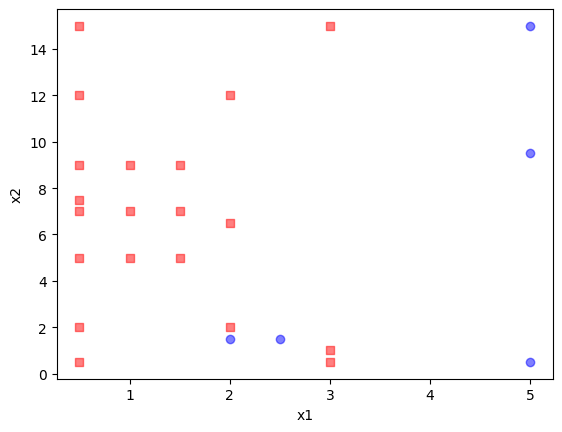

In [38]:
# Step 6: Add corners

# Concatenate EI and LCB points
x1_new = np.concatenate((np.array([x11_new_lcb]), np.array([x11_new_ei]), np.array([x12_new_lcb]), np.array([x12_new_ei])))
x2_new = np.concatenate((np.array([x21_new_lcb]), np.array([x21_new_ei]), np.array([x22_new_lcb]), np.array([x22_new_ei])))

# Add corner points and clean
X_new = np.vstack((x1_new, x2_new)).T
X_four_corners = get_four_cornes(X_grid3)
X_new_plus = np.vstack([X_new, X_four_corners])
X_new_doe3 = np.unique(X_new_plus, axis=0)
X_new_doe3, x1_new_doe3, x2_new_doe3 = remove_duplicates(X_doe3, X_new_doe3)

# Plot check
plt.scatter(x1_new_doe3, x2_new_doe3, color='b', alpha=0.5)
plt.scatter(x1mean3, x2mean3, marker='s', color='r', alpha=0.5)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

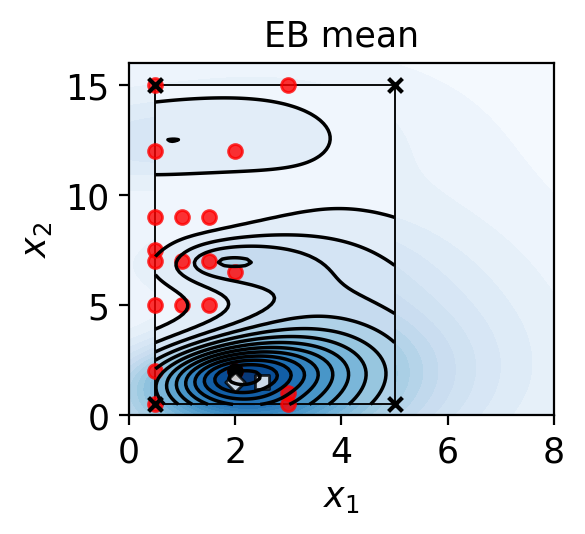

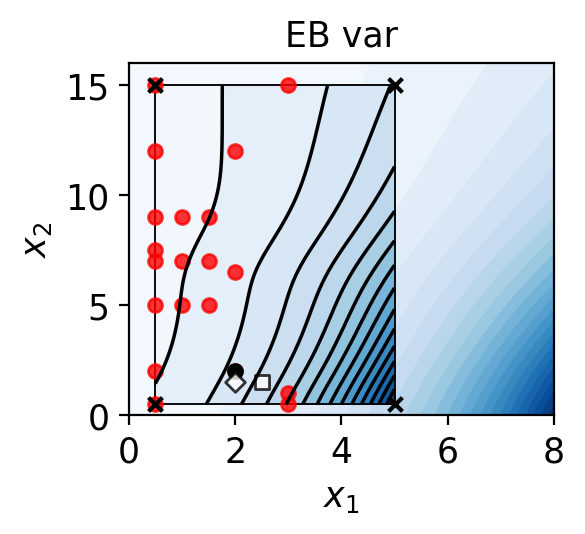

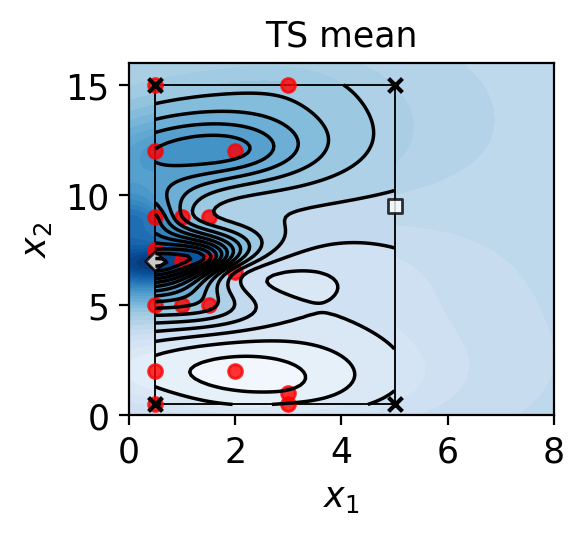

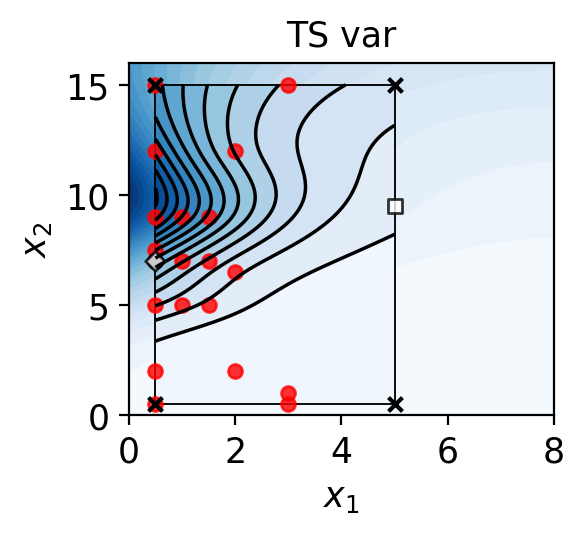

In [39]:
# Step 7: Final plots

# Four plots
four_plots(x1_grid3, x2_grid3, y1mean_mean_grid3, y1var_mean_grid3, y2mean_mean_grid3, y2var_mean_grid3,
               x1_grid_plt, x2_grid_plt, y1mean_mean_plt, y1var_mean_plt, y2mean_mean_plt, y2var_mean_plt,
               x1mean3, x2mean3, x11_best, x21_best, x12_best, x22_best,
               x11_new_ei, x21_new_ei, x12_new_ei, x22_new_ei,
               x11_new_lcb, x21_new_lcb, x12_new_lcb, x22_new_lcb,
               X_four_corners[:,0], X_four_corners[:,1], X_four_corners[:,0], X_four_corners[:,1])

# DOE 4

In [40]:
# Step 1: Load data from CSV file
data = pd.read_csv('tps_doe_4.csv')
x1mean4 = data['x1'].values.flatten() # plasticizer
x2mean4 = data['x2'].values.flatten() # starch
y1mean4 = data['y1mean'].values.flatten() # elo
y1var4 = data['y1var'].values.flatten() # elo
y2mean4 = data['y2mean'].values.flatten() # sut
y2var4 = data['y2var'].values.flatten() # sut

# Collect data
X_doe4 = np.vstack((x1mean4, x2mean4)).T

# Exploration region
X_grid4, x1_grid4, x2_grid4 = x_grid_fun(x1mean4, x2mean4, scale=1.5)

0.5 7.0 0.5 15.0


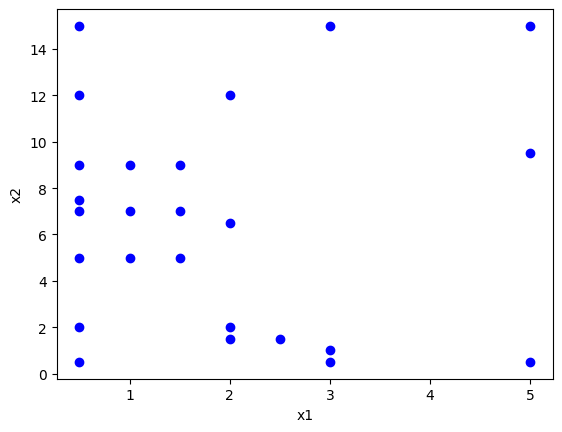

In [41]:
# Plot
plt.scatter(x1mean4, x2mean4, color='b')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In [42]:
# Step 2: Obtain the f(x_best)
min1_index = np.argmin(-y1mean4)
min2_index = np.argmin(-y2mean4)
x11_best = x1mean4[min1_index]
x21_best = x2mean4[min1_index]
x12_best = x1mean4[min2_index]
x22_best = x2mean4[min2_index]
y1_best = y1mean4[min1_index]
y2_best = y2mean4[min2_index]

print(x11_best, x21_best, y1_best)
print(x12_best, x22_best, y2_best)

2.0 2.0 69.76118695712272
0.5 7.0 2.7670553804916524


In [43]:
# Step 3: Get models and grid predictions

# Train
y1mean_doe_model4, y1var_doe_model4, y2mean_doe_model4, y2var_doe_model4 = train_model(
    x1mean4, x2mean4, y1mean4, y1var4, y2mean4, y2var4)

# Predictions
y1mean_mean_grid4, y1mean_var_grid4, y2mean_mean_grid4, y2mean_var_grid4, y1var_mean_grid4, y1var_var_grid4, y2var_mean_grid4, y2var_var_grid4 = prediction_fun(
    X_grid4, y1mean_doe_model4, y1var_doe_model4, y2mean_doe_model4, y2var_doe_model4)

# Additional predictions
y1mean_mean_plt, y1mean_var_plt, y2mean_mean_plt, y2mean_var_plt, y1var_mean_plt, y1var_var_plt, y2var_mean_plt, y2var_var_plt = prediction_fun(
    Xplt_grid, y1mean_doe_model4, y1var_doe_model4, y2mean_doe_model4, y2var_doe_model4)

In [44]:
# Step 4: Expected improvement
y1std_grid4 = np.sqrt(y1mean_var_grid4 + y1var_mean_grid4 + y1var_var_grid4)
y2std_grid4 = np.sqrt(y2mean_var_grid4 + y2var_mean_grid4 + y2var_var_grid4)

# Expected improvment of y1
ei1_grid = expected_improvement(-y1_best, -y1mean_mean_grid4, y1std_grid4)
max_ei_index = np.argmax(ei1_grid)
x11_new_ei = x1_grid4.flatten()[max_ei_index]
x21_new_ei = x2_grid4.flatten()[max_ei_index]
x11_new_ei = np.round(x11_new_ei * 2)/2 # Rounded
x21_new_ei = np.round(x21_new_ei * 2)/2 # Rounded
y1_var = y1var_mean_grid4[max_ei_index] + y1var_var_grid4[max_ei_index] + y1mean_var_grid4[max_ei_index]

# Expected improvment of y2
ei2_grid = expected_improvement(-y2_best, -y2mean_mean_grid4, y2std_grid4)
max_ei_index = np.argmax(ei2_grid)
x12_new_ei = x1_grid4.flatten()[max_ei_index]
x22_new_ei = x2_grid4.flatten()[max_ei_index]
x12_new_ei = np.round(x12_new_ei * 2)/2 # Rounded
x22_new_ei = np.round(x22_new_ei * 2)/2 # Rounded
y2_var = y2var_mean_grid4[max_ei_index] + y2var_var_grid4[max_ei_index] + y2mean_var_grid4[max_ei_index]

# Print
iter = 3
print('iter=', iter)
print(x11_new_ei, x21_new_ei)
print(x12_new_ei, x22_new_ei)

# Max EI values
max_ei1= np.max(ei1_grid)
max_ei2= np.max(ei2_grid)

# Save results in a CSV file
df_res = pd.DataFrame({'iter': [iter],
                       'x11_best': [x11_best], 'x21_best': [x21_best], 'y1_best': [y1_best], 'y1_var': [y1_var], 'max_ei1': [max_ei1],
                       'x12_best': [x12_best], 'x22_best': [x22_best], 'y2_best': [y2_best], 'y2_var': [y2_var], 'max_ei2': [max_ei2]})

# Save results
df_res1 = pd.read_csv('results3.csv')
df_res2 = pd.concat([df_res1, df_res], ignore_index=True)
df_res2.to_csv('results4.csv', index=False)

iter= 3
2.0 2.5
0.5 7.0


In [45]:
# Step 5: Lower confidence bound (LCB)

# Initialization
kappa1 = 0.0
kappa2 = 0.0
x11_new_lcb = x11_new_ei
x21_new_lcb = x21_new_ei
x12_new_lcb = x12_new_ei
x22_new_lcb = x22_new_ei

# Lower confidence bound of y1
while (x11_new_lcb == x11_new_ei and x21_new_lcb == x21_new_ei) and kappa1 < 2**12:
  lcb1_grid = -y1mean_mean_grid4 - kappa1*y1std_grid4
  min_lcb_index = np.argmin(lcb1_grid)
  x11_new_lcb = x1_grid4.flatten()[min_lcb_index]
  x21_new_lcb = x2_grid4.flatten()[min_lcb_index]
  x11_new_lcb = np.round(x11_new_lcb * 2)/2 # Rounded
  x21_new_lcb = np.round(x21_new_lcb * 2)/2 # Rounded
  # kappa1 = max(2*kappa1, 1)
  kappa1 = 2**kappa1
  kappa1 += 1

# Lower confidence bound of y2
while (x12_new_lcb == x12_new_ei and x22_new_lcb == x22_new_ei) and kappa2 < 2**12:
  lcb2_grid = -y2mean_mean_grid4 - kappa2*y2std_grid4
  min_lcb_index = np.argmin(lcb2_grid)
  x12_new_lcb = x1_grid4.flatten()[min_lcb_index]
  x22_new_lcb = x2_grid4.flatten()[min_lcb_index]
  x12_new_lcb = np.round(x12_new_lcb * 2)/2 # Rounded
  x22_new_lcb = np.round(x22_new_lcb * 2)/2 # Rounded
  kappa2 = 2**kappa2

# Print
print(x11_new_ei, x21_new_ei)
print(x12_new_ei, x22_new_ei)
print(x11_new_lcb, x21_new_lcb)
print(x12_new_lcb, x22_new_lcb)

2.0 2.5
0.5 7.0
4.5 2.0
7.0 5.0


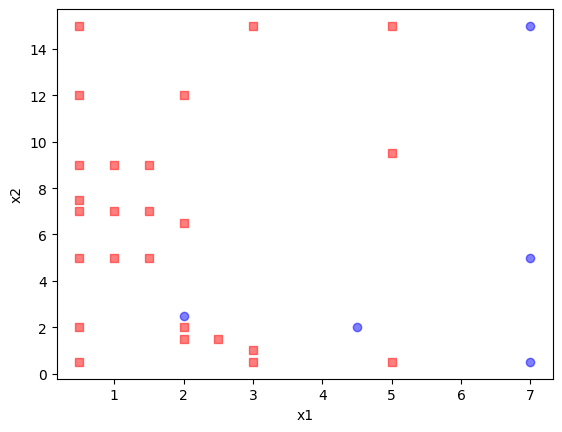

In [46]:
# Step 6: Add corners

# Concatenate EI and LCB points
x1_new = np.concatenate((np.array([x11_new_lcb]), np.array([x11_new_ei]), np.array([x12_new_lcb]), np.array([x12_new_ei])))
x2_new = np.concatenate((np.array([x21_new_lcb]), np.array([x21_new_ei]), np.array([x22_new_lcb]), np.array([x22_new_ei])))

# Add corner points and clean
X_new = np.vstack((x1_new, x2_new)).T
X_four_corners = get_four_cornes(X_grid4)
X_new_plus = np.vstack([X_new, X_four_corners])
X_new_doe4= np.unique(X_new_plus, axis=0)
X_new_doe4, x1_new_doe4, x2_new_doe4 = remove_duplicates(X_doe4, X_new_doe4)

# Plot check
plt.scatter(x1_new_doe4, x2_new_doe4, color='b', alpha=0.5)
plt.scatter(x1mean4, x2mean4, marker='s', color='r', alpha=0.5)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

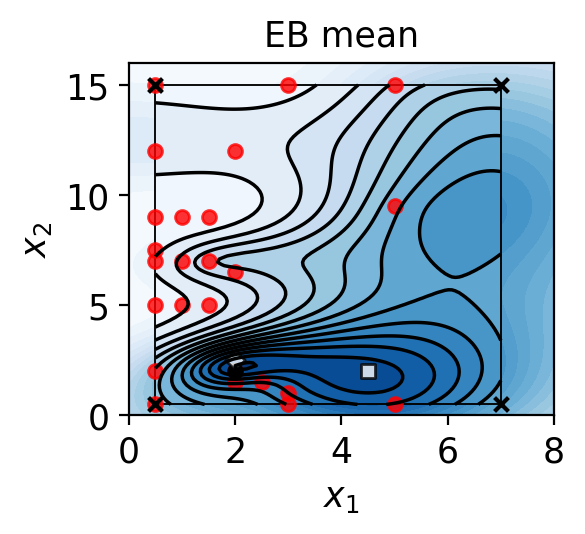

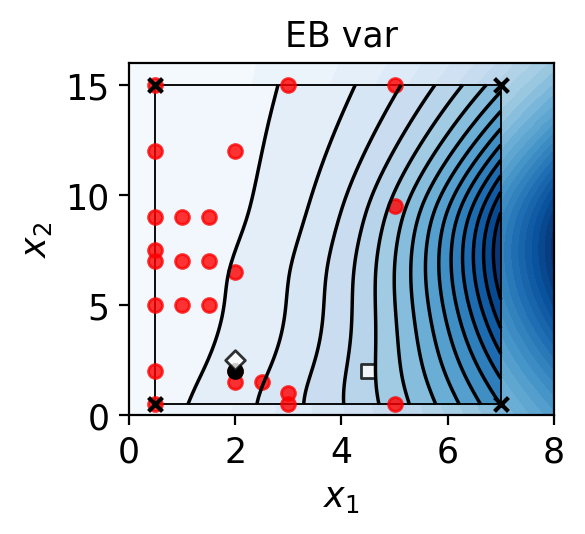

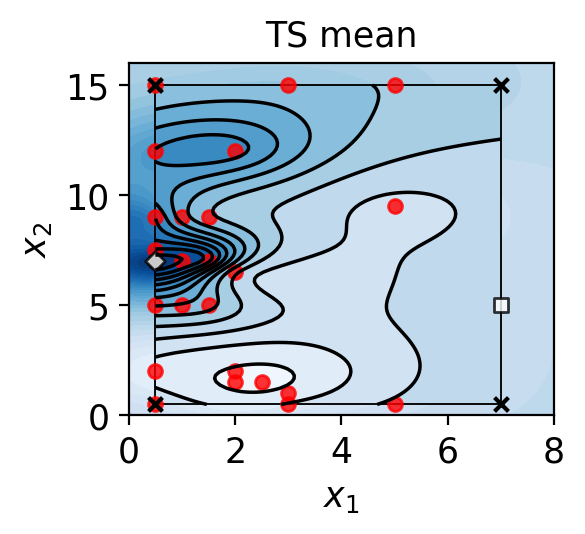

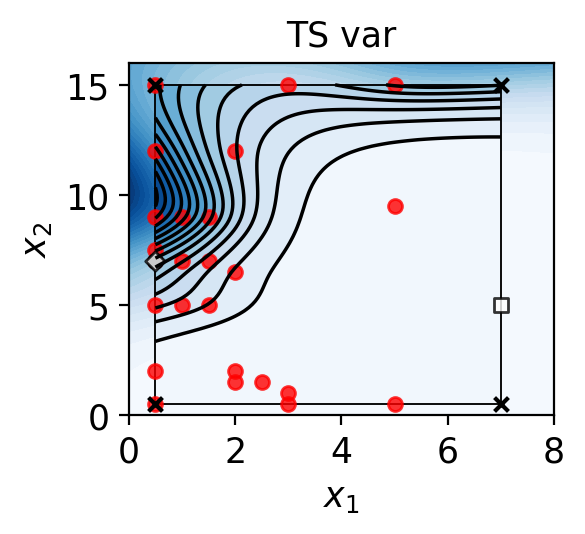

In [47]:
# Step 7: Final plots

# Four plots
four_plots(x1_grid4, x2_grid4, y1mean_mean_grid4, y1var_mean_grid4, y2mean_mean_grid4, y2var_mean_grid4,
               x1_grid_plt, x2_grid_plt, y1mean_mean_plt, y1var_mean_plt, y2mean_mean_plt, y2var_mean_plt,
               x1mean4, x2mean4, x11_best, x21_best, x12_best, x22_best,
               x11_new_ei, x21_new_ei, x12_new_ei, x22_new_ei,
               x11_new_lcb, x21_new_lcb, x12_new_lcb, x22_new_lcb,
               X_four_corners[:,0], X_four_corners[:,1], X_four_corners[:,0], X_four_corners[:,1])

# DOE 5

In [48]:
# Step 1: Load data from CSV file
data = pd.read_csv('tps_doe_5.csv')
x1mean5 = data['x1'].values.flatten() # plasticizer
x2mean5 = data['x2'].values.flatten() # starch
y1mean5 = data['y1mean'].values.flatten() # elo
y1var5 = data['y1var'].values.flatten() # elo
y2mean5 = data['y2mean'].values.flatten() # sut
y2var5 = data['y2var'].values.flatten() # sut

# Collect data
X_doe5 = np.vstack((x1mean5, x2mean5)).T

# Exploration region
X_grid5, x1_grid5, x2_grid5 = x_grid_fun(x1mean5, x2mean5, scale=1.5)

0.5 7.0 0.5 15.0


In [49]:
# Step 2: Obtain the f(x_best)
min1_index = np.argmin(-y1mean5)
min2_index = np.argmin(-y2mean5)
x11_best = x1mean5[min1_index]
x21_best = x2mean5[min1_index]
x12_best = x1mean5[min2_index]
x22_best = x2mean5[min2_index]
y1_best = y1mean5[min1_index]
y2_best = y2mean5[min2_index]

print(x11_best, x21_best, y1_best)
print(x12_best, x22_best, y2_best)

4.5 2.0 96.7148512355052
0.5 7.0 2.7670553804916524


In [50]:
# Step 3: Get models and grid predictions

# Train
y1mean_doe_model5, y1var_doe_model5, y2mean_doe_model5, y2var_doe_model5 = train_model(
    x1mean5, x2mean5, y1mean5, y1var5, y2mean5, y2var5)

# Predictions
y1mean_mean_grid5, y1mean_var_grid5, y2mean_mean_grid5, y2mean_var_grid5, y1var_mean_grid5, y1var_var_grid5, y2var_mean_grid5, y2var_var_grid5 = prediction_fun(
    X_grid5, y1mean_doe_model5, y1var_doe_model5, y2mean_doe_model5, y2var_doe_model5)

# Additional predictions
y1mean_mean_plt, y1mean_var_plt, y2mean_mean_plt, y2mean_var_plt, y1var_mean_plt, y1var_var_plt, y2var_mean_plt, y2var_var_plt = prediction_fun(
    Xplt_grid, y1mean_doe_model5, y1var_doe_model5, y2mean_doe_model5, y2var_doe_model5)


In [51]:
# Step 4: Expected improvement
y1std_grid5 = np.sqrt(y1mean_var_grid5 + y1var_mean_grid5 + y1var_var_grid5)
y2std_grid5 = np.sqrt(y2mean_var_grid5 + y2var_mean_grid5 + y2var_var_grid5)

# Expected improvment of y1
ei1_grid = expected_improvement(-y1_best, -y1mean_mean_grid5, y1std_grid5)
max_ei_index = np.argmax(ei1_grid)
x11_new_ei = x1_grid5.flatten()[max_ei_index]
x21_new_ei = x2_grid5.flatten()[max_ei_index]
x11_new_ei = np.round(x11_new_ei * 2)/2 # Rounded
x21_new_ei = np.round(x21_new_ei * 2)/2 # Rounded
y1_var = y1var_mean_grid5[max_ei_index] + y1var_var_grid5[max_ei_index] + y1mean_var_grid5[max_ei_index]

# Expected improvment of y2
ei2_grid = expected_improvement(-y2_best, -y2mean_mean_grid5, y2std_grid5)
max_ei_index = np.argmax(ei2_grid)
x12_new_ei = x1_grid5.flatten()[max_ei_index]
x22_new_ei = x2_grid5.flatten()[max_ei_index]
x12_new_ei = np.round(x12_new_ei * 2)/2 # Rounded
x22_new_ei = np.round(x22_new_ei * 2)/2 # Rounded
y2_var = y2var_mean_grid5[max_ei_index] + y2var_var_grid5[max_ei_index] + y2mean_var_grid5[max_ei_index]

# Print
iter = 4
print('iter=', iter)
print(x11_new_ei, x21_new_ei)
print(x12_new_ei, x22_new_ei)

# Max EI values
max_ei1= np.max(ei1_grid)
max_ei2= np.max(ei2_grid)

# Save results in a CSV file
df_res = pd.DataFrame({'iter': [iter],
                       'x11_best': [x11_best], 'x21_best': [x21_best], 'y1_best': [y1_best], 'y1_var': [y1_var], 'max_ei1': [max_ei1],
                       'x12_best': [x12_best], 'x22_best': [x22_best], 'y2_best': [y2_best], 'y2_var': [y2_var],'max_ei2': [max_ei2]})

# Save results
df_res1 = pd.read_csv('results4.csv')
df_res2 = pd.concat([df_res1, df_res], ignore_index=True)
df_res2.to_csv('results5.csv', index=False)


iter= 4
5.0 2.0
0.5 7.0


In [52]:
# Step 5: Lower confidence bound (LCB)

# Initialization
kappa1 = 0.0
kappa2 = 0.0
x11_new_lcb = x11_new_ei
x21_new_lcb = x21_new_ei
x12_new_lcb = x12_new_ei
x22_new_lcb = x22_new_ei

# Lower confidence bound of y1
while (x11_new_lcb == x11_new_ei and x21_new_lcb == x21_new_ei) and kappa1 < 2**12:
  lcb1_grid = -y1mean_mean_grid5 - kappa1*y1std_grid5
  min_lcb_index = np.argmin(lcb1_grid)
  x11_new_lcb = x1_grid5.flatten()[min_lcb_index]
  x21_new_lcb = x2_grid5.flatten()[min_lcb_index]
  x11_new_lcb = np.round(x11_new_lcb * 2)/2 # Rounded
  x21_new_lcb = np.round(x21_new_lcb * 2)/2 # Rounded
  # kappa1 = max(2*kappa1, 1)
  kappa1 = 2**kappa1
  kappa1 += 1

# Lower confidence bound of y2
while (x12_new_lcb == x12_new_ei and x22_new_lcb == x22_new_ei) and kappa2 < 2**12:
  lcb2_grid = -y2mean_mean_grid5 - kappa2*y2std_grid5
  min_lcb_index = np.argmin(lcb2_grid)
  x12_new_lcb = x1_grid5.flatten()[min_lcb_index]
  x22_new_lcb = x2_grid5.flatten()[min_lcb_index]
  x12_new_lcb = np.round(x12_new_lcb * 2)/2 # Rounded
  x22_new_lcb = np.round(x22_new_lcb * 2)/2 # Rounded
  kappa2 = 2**kappa2

# Print
print(x11_new_ei, x21_new_ei)
print(x12_new_ei, x22_new_ei)
print(x11_new_lcb, x21_new_lcb)
print(x12_new_lcb, x22_new_lcb)

5.0 2.0
0.5 7.0
4.5 2.0
7.0 11.5


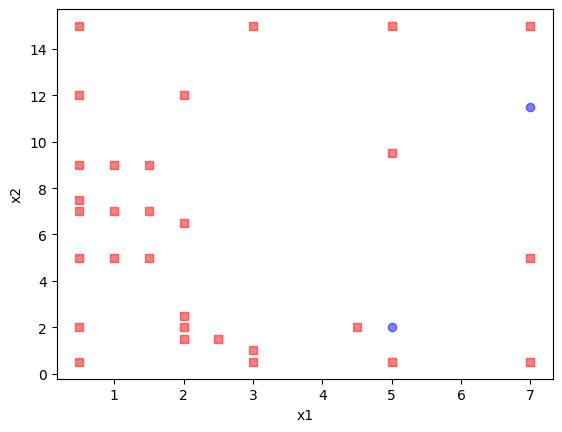

In [53]:
# Step 6: Add corners

# Concatenate EI and LCB points
x1_new = np.concatenate((np.array([x11_new_lcb]), np.array([x11_new_ei]), np.array([x12_new_lcb]), np.array([x12_new_ei])))
x2_new = np.concatenate((np.array([x21_new_lcb]), np.array([x21_new_ei]), np.array([x22_new_lcb]), np.array([x22_new_ei])))

# Add corner points and clean
X_new = np.vstack((x1_new, x2_new)).T
X_four_corners = get_four_cornes(X_grid5)
X_new_plus = np.vstack([X_new, X_four_corners])
X_new_doe5 = np.unique(X_new_plus, axis=0)
X_new_doe5, x1_new_doe5, x2_new_doe5 = remove_duplicates(X_doe5, X_new_doe5)

# Plot check
plt.scatter(x1_new_doe5, x2_new_doe5, color='b', alpha=0.5)
plt.scatter(x1mean5, x2mean5, marker='s', color='r', alpha=0.5)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

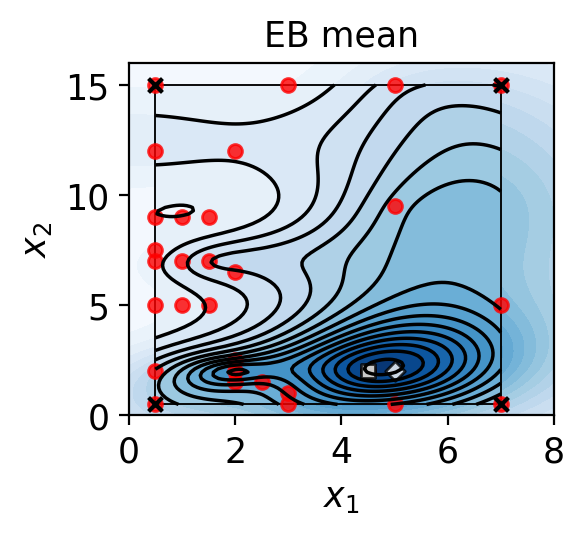

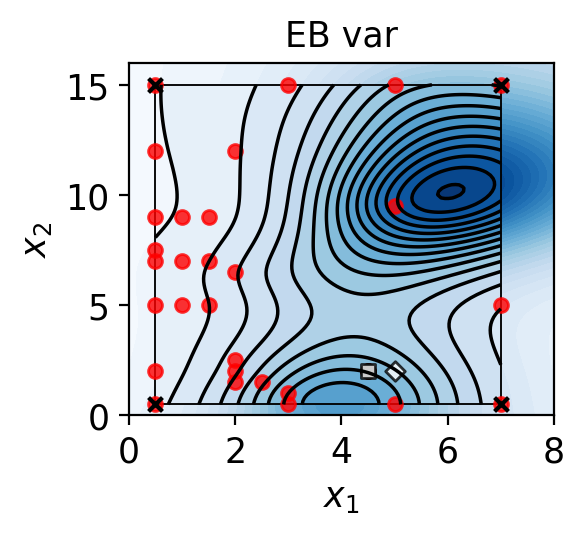

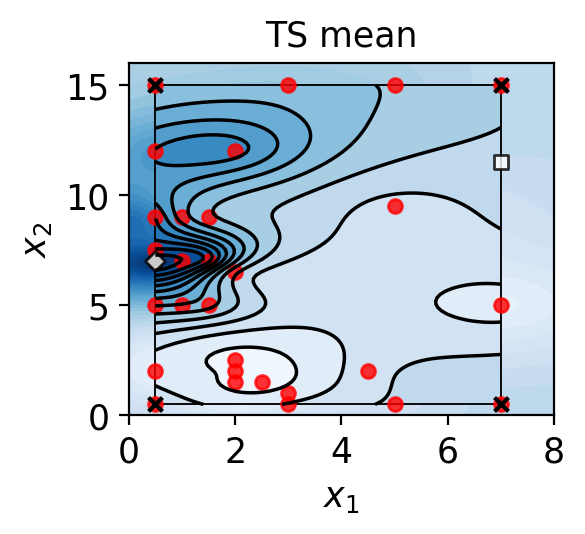

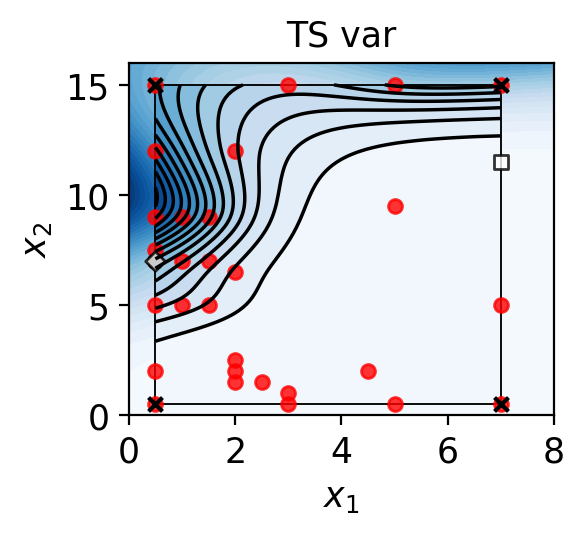

In [54]:
# Step 7: Final plots

# Four plots
four_plots(x1_grid5, x2_grid5, y1mean_mean_grid5, y1var_mean_grid5, y2mean_mean_grid5, y2var_mean_grid5,
               x1_grid_plt, x2_grid_plt, y1mean_mean_plt, y1var_mean_plt, y2mean_mean_plt, y2var_mean_plt,
               x1mean5, x2mean5, x11_best, x21_best, x12_best, x22_best,
               x11_new_ei, x21_new_ei, x12_new_ei, x22_new_ei,
               x11_new_lcb, x21_new_lcb, x12_new_lcb, x22_new_lcb,
               X_four_corners[:,0], X_four_corners[:,1], X_four_corners[:,0], X_four_corners[:,1])

# Extra plots

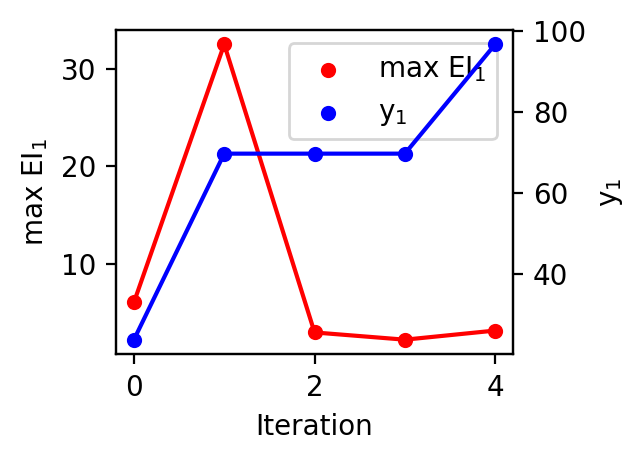

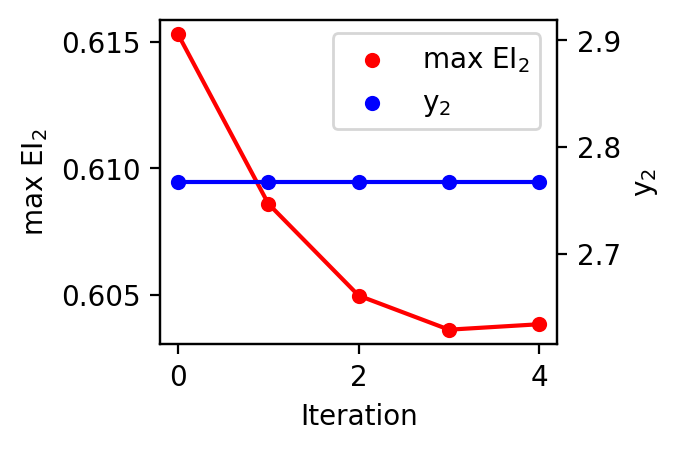

In [55]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
def points_and_lines_plot2(iter, y1_val, y2_val, y1_name='Values', y2_name='Values2', dpi=300):
  # Plotting
  scale = 2
  fontsize = 5*scale
  linewidth = 1*scale
  mark_size = 10*scale

  # Plot preparation
  fig, ax = plt.subplots(1, 1, figsize=(3.25, 2.75), dpi=dpi)
  fig.tight_layout(pad=3.0)

  # ax.fill_between(iter, y_low, y_high, color='silver', alpha=0.5)
  # ax.axhline(y=y_low, color='k', linestyle='-', linewidth=linewidth/2)
  # ax.axhline(y=y_high, color='k', linestyle='-', linewidth=linewidth/2)
  line1 = ax.scatter(iter, y1_val, color='r', s=mark_size, label=y1_name, alpha=1)
  ax.plot(iter, y1_val, color='r', alpha=1)

  # ax.set_xticks([0, 0.5, 1])
  ax.tick_params(axis='x', labelsize=fontsize)
  ax.tick_params(axis='y', labelsize=fontsize)
  ax.set_xlabel("Iteration", fontsize=fontsize)
  ax.set_ylabel(y1_name, fontsize=fontsize)
  ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.0f}"))

  ax2 = ax.twinx()
  line2 = ax2.scatter(iter, y2_val, color='b', s=mark_size, label=y2_name, alpha=1)
  ax2.plot(iter, y2_val, color='b', alpha=1)

  ax2.tick_params(axis='y', labelsize=fontsize)
  ax2.set_ylabel(y2_name, fontsize=fontsize)
  ax2.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.0f}"))

  # ax.legend(fontsize=fontsize)
  # ax2.legend(fontsize=fontsize)

  # Combine the legends from both axes
  lines = [line1, line2]
  labels = [line.get_label() for line in lines]

  # Place the legend outside the plot
  ax.legend(lines, labels, loc='upper left', bbox_to_anchor=(0.4, 1.), fontsize=fontsize)


# Plot
df = pd.read_csv('results5.csv')
df = pd.DataFrame({'iter': df['iter'], 'y1': df['y1_best'], 'y2': df['y2_best'], 'max_ei1': df['max_ei1'], 'max_ei2': df['max_ei2']})
points_and_lines_plot2(iter=df['iter'], y1_val=df['max_ei1'], y2_val=df['y1'], y1_name='max EI$_1$', y2_name='y$_1$', dpi=200)
points_and_lines_plot2(iter=df['iter'], y1_val=df['max_ei2'], y2_val=df['y2'], y1_name='max EI$_2$', y2_name='y$_2$', dpi=200)

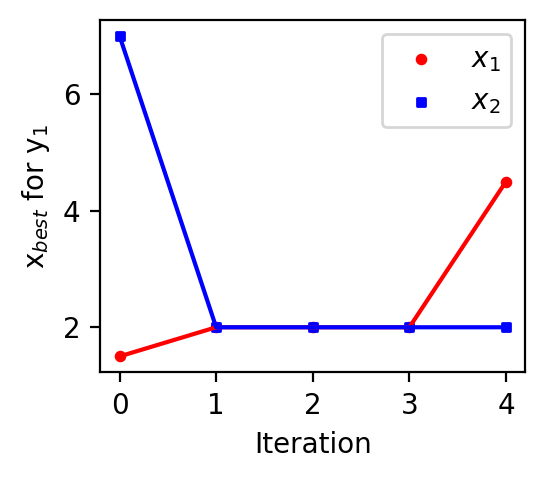

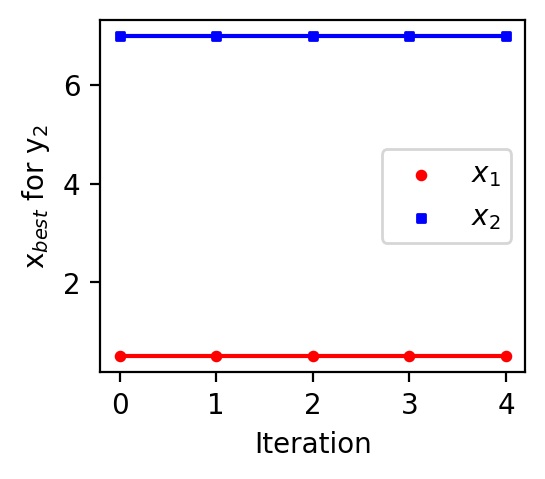

In [56]:
def points2_plot(iter, y1_val, y2_val, y_name='Values', dpi=300):
  # Plotting
  scale = 2
  fontsize = 5*scale
  linewidth = 1*scale
  mark_size = 10*scale/2

  # Plot preparation
  fig, ax = plt.subplots(1, 1, figsize=(3.25, 2.75), dpi=dpi)
  fig.tight_layout(pad=2.5)

  # ax.fill_between(iter, y_low, y_high, color='silver', alpha=0.5)
#   ax.axhline(y=y_ref, color='k', linestyle='-', linewidth=linewidth/2)
  ax.scatter(iter, y1_val, color='r', marker='o', s=mark_size, label='$x_1$', alpha=1)
  ax.scatter(iter, y2_val, color='b', marker='s', s=mark_size, label='$x_2$', alpha=1)
  ax.plot(iter, y1_val, color='r')
  ax.plot(iter, y2_val, color='b')

  # ax.set_xticks([0, 0.5, 1])
  ax.tick_params(axis='x', labelsize=fontsize)
  ax.tick_params(axis='y', labelsize=fontsize)
  ax.set_xlabel("Iteration", fontsize=fontsize)
  ax.set_ylabel(y_name, fontsize=fontsize)

  # ax.set_ylim(0, 0.5)
  ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.0f}"))
  ax.legend(fontsize=fontsize)

# Plot
df = pd.read_csv('results5.csv')
df = pd.DataFrame({'iter': df['iter'], 'x11_best': df['x11_best'], 'x21_best': df['x21_best'], 'x12_best': df['x12_best'], 'x22_best': df['x22_best'] })
points2_plot(iter=df['iter'], y1_val=df['x11_best'], y2_val=df['x21_best'], y_name='x$_{best}$ for y$_1$', dpi=200)
points2_plot(iter=df['iter'], y1_val=df['x12_best'], y2_val=df['x22_best'], y_name='x$_{best}$ for y$_2$', dpi=200)


In [57]:
def plot_distribution2(x, y_best, y_var, y_lim, y_name='Values', dpi=300):
  # Plotting
  scale = 1
  fontsize = 5*scale
  linewidth = 1*scale
  mark_size = 5*scale/2
  color = 'lightsteelblue'

  # Plot preparation
  fig, ax = plt.subplots(1, 1, figsize=(3.5, 2.5), dpi=dpi)
  fig.tight_layout(pad=2.5)

  y_std = np.sqrt(y_var)
  lb = y_best - 1.96*y_std
  ub = y_best + 1.96*y_std

  ax.fill_between(x, lb, ub, color=color, alpha=1 - 0.05)
  ax.plot(x, lb, color=color)
  ax.plot(x, ub, color=color)
  ax.scatter(x, y_best, color="gray", alpha=0.8)

  # Error bars
  ax.errorbar(x, y_best, yerr=1.96*y_std, fmt='o', capsize = mark_size/2, color='k', alpha=0.5)

  ax.set_ylim(y_lim[0], y_lim[1])
  ax.set_xlabel('Iteration')
  ax.set_ylabel(y_name)

  # Save
  # os.makedirs(save_dir, exist_ok=True)
  # ax.figure.savefig(f'{save_dir}iter_vs_{y_name}.png', dpi=dpi)


In [58]:
def plot_distribution3(x, y_best, y_var, t_val, y_lim, y_name='Values', dpi=300):
  # Plotting
  scale = 1
  fontsize = 5*scale
  linewidth = 1*scale
  mark_size = 5*scale/2
  color = 'lightsteelblue'

  # Plot preparation
  fig, ax = plt.subplots(1, 1, figsize=(3.5, 2.5), dpi=dpi)
  fig.tight_layout(pad=2.5)

  y_std = np.sqrt(y_var)
  lb = y_best - t_val*y_std
  ub = y_best + t_val*y_std

  ax.fill_between(x, lb, ub, color=color, alpha=1 - 0.05)
  ax.plot(x, lb, color=color)
  ax.plot(x, ub, color=color)
  ax.scatter(x, y_best, color="gray", alpha=0.8)

  # Error bars
  ax.errorbar(x, y_best, yerr=t_val*y_std, fmt='o', capsize = mark_size/2, color='k', alpha=0.5)

  ax.set_ylim(y_lim[0], y_lim[1])
  ax.set_xlabel('Iteration')
  ax.set_ylabel(y_name)


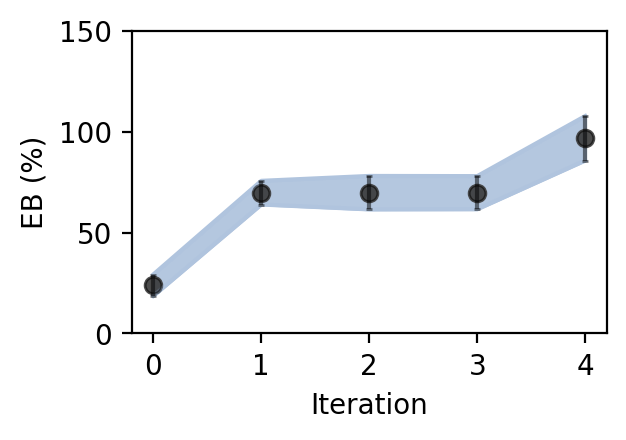

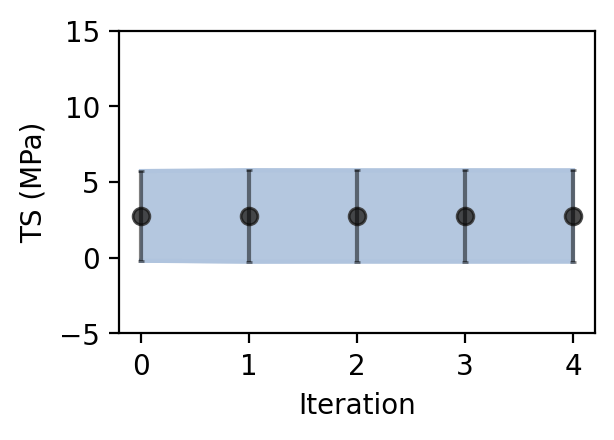

In [59]:
# Final plots
df = pd.read_csv('results5.csv')
y1_best = df['y1_best'].to_numpy()
y1_var = df['y1_var'].to_numpy()
y2_best = df['y2_best'].to_numpy()
y2_var = df['y2_var'].to_numpy()
iter = df['iter'].to_numpy()
# nexp = df['nexp'].to_numpy()

# Correct for GPs.
plot_distribution2(iter, y1_best, y1_var, [0, 150], y_name='EB (%)', dpi=200)
plot_distribution2(iter, y2_best, y2_var, [-5, 15], y_name='TS (MPa)', dpi=200)
